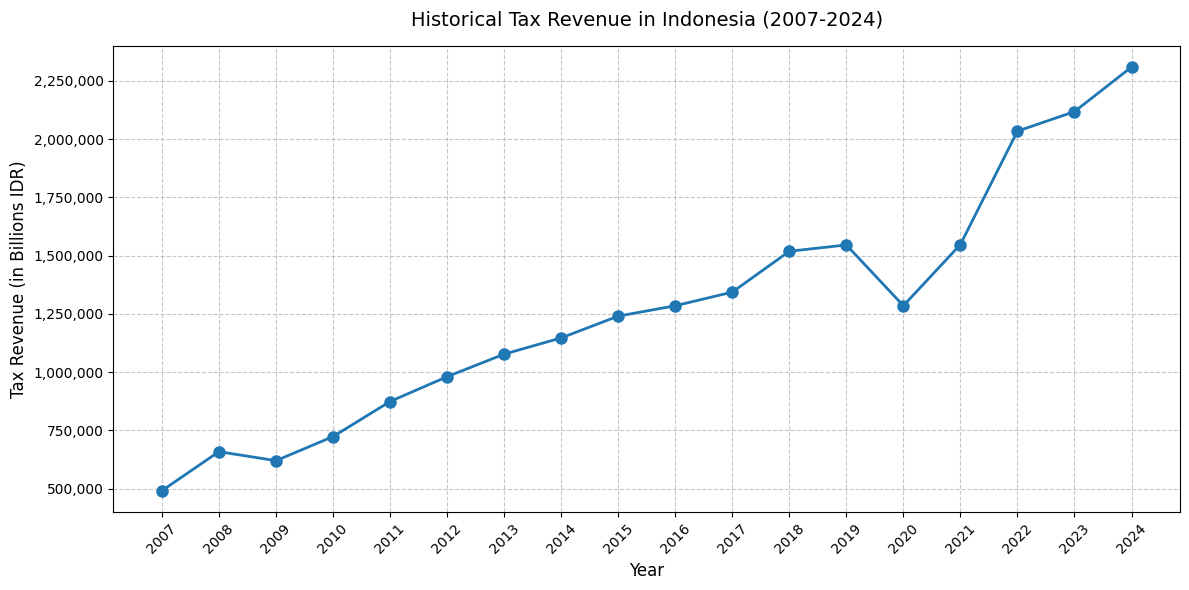

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing


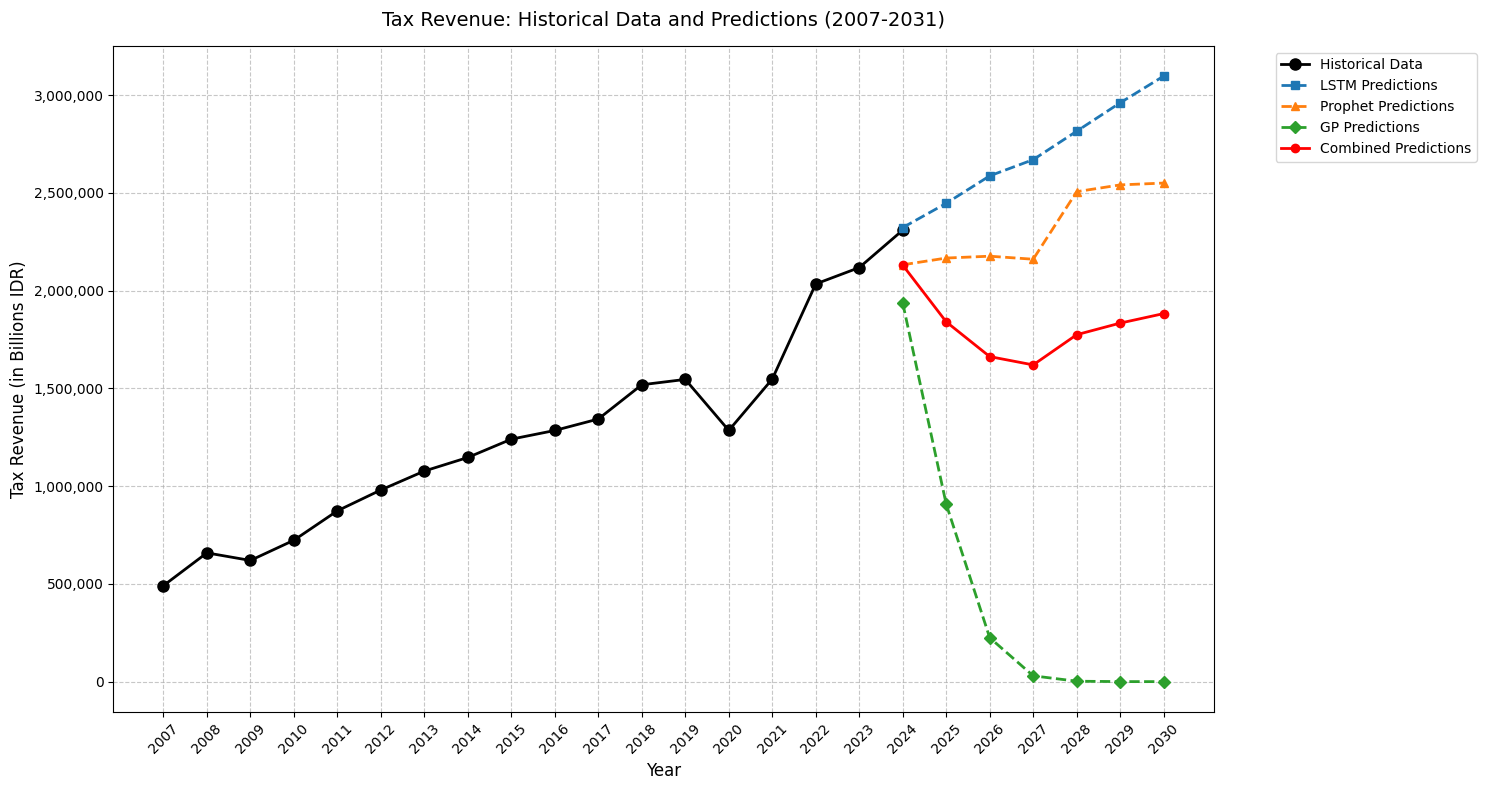


Predictions for 2024-2031:

Year		LSTM		Prophet		GP		Combined
--------------------------------------------------------------------------------
2024		2322961.00		2132532.26		1936828.63		2130773.96
2025		2447140.75		2167099.10		907762.60		1840667.49
2026		2587527.00		2176533.18		224592.57		1662884.25
2027		2670499.50		2160990.38		29612.86		1620367.58
2028		2815908.25		2506727.34		2109.48		1774915.02
2029		2961398.50		2541294.18		81.95		1834258.21
2030		3097893.00		2550728.25		1.75		1882874.33


In [4]:
# %pip install pandas numpy scikit-learn tensorflow matplotlib prophet

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Load and concatenate data
dfs = []
for i in range(1, 7):
    df = pd.read_csv(f'./data/Realisasi Pendapatan Negara, {2007 + (i-1)*3}-{2009 + (i-1)*3}.csv')
    penerimaan_pajak = df[df.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
    cleaned_df = pd.DataFrame({
        'Tahun': [str(year) for year in range(2007 + (i-1)*3, 2010 + (i-1)*3)],
        'Penerimaan Pajak': [str(value) for value in penerimaan_pajak.values.flatten()]
    })
    dfs.append(cleaned_df)

data = pd.concat(dfs).reset_index(drop=True)
data['Penerimaan Pajak'] = pd.to_numeric(data['Penerimaan Pajak'], errors='coerce').fillna(0)

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(data['Tahun'], data['Penerimaan Pajak'], marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Historical Tax Revenue in Indonesia (2007-2024)', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tax Revenue (in Billions IDR)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# LSTM Implementation
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['Penerimaan Pajak'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
dataset = data_scaled
train_size = int(len(dataset) * 0.67)
train, test = dataset[0:train_size], dataset[train_size:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Enhanced LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Increased epochs
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=0)

# Adjust the predictions to extend until 2031 (7 years from 2024)
future_years = [str(year) for year in range(2024, 2032)]

# LSTM Implementation
# Modified to predict 7 years ahead
lstm_future = []
last_sequence = data_scaled[-look_back:]
last_sequence = np.reshape(last_sequence, (1, look_back, 1))

for _ in range(7):  # Changed from 5 to 7 years
    next_pred = model.predict(last_sequence)
    lstm_future.append(next_pred[0,0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0,-1,0] = next_pred

lstm_future = np.array(lstm_future).reshape(-1, 1)
lstm_future = scaler.inverse_transform(lstm_future)


# Prophet Implementation
prophet_data = pd.DataFrame({
    'ds': pd.to_datetime(data['Tahun']),
    'y': data['Penerimaan Pajak']
})

prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_data)

# Extend Prophet predictions to 2031
future_dates = prophet_model.make_future_dataframe(periods=7, freq='Y')  # Changed from 5 to 7 years
# Gaussian Process Implementation
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP model
X_train = np.arange(len(data)).reshape(-1, 1)
y_train = data['Penerimaan Pajak'].values
gp.fit(X_train, y_train)

# Extend GP predictions to 2031
X_pred = np.arange(len(data), len(data) + 7).reshape(-1, 1)  # Changed from 5 to 7 years
y_pred, sigma = gp.predict(X_pred, return_std=True)
X_pred = np.arange(len(data), len(data) + 7).reshape(-1, 1)  # Changed from 5 to 7 years
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plot predictions
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(data['Tahun'], data['Penerimaan Pajak'], marker='o', label='Historical Data', linewidth=2, color='black', markersize=8)

# Plot predictions
future_years = [str(year) for year in range(2024, 2031)]  # Updated range

# LSTM predictions
plt.plot(future_years, lstm_future, marker='s', label='LSTM Predictions', linestyle='--', linewidth=2)

# Prophet predictions
prophet_predictions = prophet_forecast['yhat'][-7:].values  # Changed from 5 to 7 years
plt.plot(future_years, prophet_predictions, marker='^', label='Prophet Predictions', linestyle='--', linewidth=2)

# Gaussian Process predictions
plt.plot(future_years, y_pred, marker='D', label='GP Predictions', linestyle='--', linewidth=2)

# Calculate combined predictions
combined_predictions = (lstm_future.flatten() + prophet_predictions + y_pred) / 3
plt.plot(future_years, combined_predictions, marker='o', label='Combined Predictions', linestyle='-', linewidth=2, color='red')

# Formatting
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Tax Revenue: Historical Data and Predictions (2007-2031)', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tax Revenue (in Billions IDR)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the predictions
print("\nPredictions for 2024-2031:")
print("\nYear\t\tLSTM\t\tProphet\t\tGP\t\tCombined")
print("-" * 80)
for i, year in enumerate(future_years):
    print(f"{year}\t\t{lstm_future[i][0]:.2f}\t\t{prophet_predictions[i]:.2f}\t\t{y_pred[i]:.2f}\t\t{combined_predictions[i]:.2f}")